In [1]:
#@title Install libraries + Log in to 🤗
import os
from IPython.display import clear_output
import time
if not os.path.exists("installed.txt"):
    # red lines, it's fines, that's what i always say
    !pip install transformers diffusers lpips -q
    # !pip install git+https://github.com/openai/CLIP -q
    !pip install open_clip_torch -q
    !pip install wget -q
    !sudo apt-get install git-lfs
    !cat "test" > installed.txt
    !mkdir /content/output
    print("Installed libraries")
    time.sleep(1) # just so that the user can see a glimpse of the print to know it went succesfuly
    clear_output(wait=False)
else:
    print("Libraries already installed.")

from huggingface_hub import notebook_login
notebook_login()

Libraries already installed.


### Setup program files

top 10 pages of danbooru tags, prompt building blocks from clip interrogator

In [2]:
%%writefile doohickey-slim.py
import torch
torch.manual_seed(0)
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm, trange
from torch import autocast
import PIL.Image as PImage
import numpy
from torchvision import transforms
import torchvision.transforms.functional as f
import random
import requests
from io import BytesIO
import sys

model_name = sys.argv[4]
model_type = "diffusers"

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
offload_device = "cpu"

vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_auth_token=True).cpu().to(torch.bfloat16)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder", use_auth_token=True).cpu().to(torch.bfloat16)
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_auth_token=True).cpu().to(torch.bfloat16)

def requires_grad(model, val=False):
    for param in model.parameters():
        param.requires_grad = val

requires_grad(vae)
requires_grad(text_encoder)
requires_grad(unet)

#@title Set up generation loop

to_tensor_tfm = transforms.ToTensor()

# mismatch of tons of image encoding / decoding / loading functions i cant be asked to clean up right now

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
      with autocast("cuda"):
        latent = vae.encode(to_tensor_tfm(input_im.convert("RGB")).unsqueeze(0).to(torch_device)*2-1).latent_dist # Note scaling
#   print(latent)
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

def get_latent_from_url(url, size=(512,512)):
    response = requests.get(url)
    img = PImage.open(BytesIO(response.content))
    img = img.resize(size).convert("RGB")
    latent = pil_to_latent(img)
    return latent

def scale_and_decode(latents):
    with autocast("cuda"):
        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(latents).sample.squeeze(0)
        image = f.to_pil_image((image / 2 + 0.5).clamp(0, 1))
        return image

def fetch(url_or_path):
    import io
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return PImage.open(fd).convert('RGB')
    return PImage.open(open(url_or_path, 'rb')).convert('RGB')

"""
grabs all text up to the first occurrence of ':' 
uses the grabbed text as a sub-prompt, and takes the value following ':' as weight
if ':' has no value defined, defaults to 1.0
repeats until no text remaining
"""
def split_weighted_subprompts(text, split=":"):
    remaining = len(text)
    prompts = []
    weights = []
    while remaining > 0:
        if split in text:
            idx = text.index(split) # first occurrence from start
            # grab up to index as sub-prompt
            prompt = text[:idx]
            remaining -= idx
            # remove from main text
            text = text[idx+1:]
            # find value for weight 
            if " " in text:
                idx = text.index(" ") # first occurence
            else: # no space, read to end
                idx = len(text)
            if idx != 0:
                try:
                    weight = float(text[:idx])
                except: # couldn't treat as float
                    print(f"Warning: '{text[:idx]}' is not a value, are you missing a space?")
                    weight = 1.0
            else: # no value found
                weight = 1.0
            # remove from main text
            remaining -= idx
            text = text[idx+1:]
            # append the sub-prompt and its weight
            prompts.append(prompt)
            weights.append(weight)
        else: # no : found
            if len(text) > 0: # there is still text though
                # take remainder as weight 1
                prompts.append(text)
                weights.append(1.0)
            remaining = 0
    print(prompts, weights)
    return prompts, weights 


# from some stackoverflow comment
import numpy as np
def lerp(a, b, x):
    "linear interpolation"
    return a + x * (b - a)
def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3
def gradient(h, x, y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y
def perlin(x, y, seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    # coordinates of the top-left
    xi, yi = x.astype(int), y.astype(int)
    # internal coordinates
    xf, yf = x - xi, y - yi
    # fade factors
    u, v = fade(xf), fade(yf)
    # noise components
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    # combine noises
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)  # FIX1: I was using n10 instead of n01
    return lerp(x1, x2, v)  # FIX2: I also had to reverse x1 and x2 here

def sample(args):
    global in_channels
    global text_encoder # uugghhhghhghgh
    global vae # UUGHGHHGHGH
    global unet # .hggfkgjks;ldjf
    # prompt = args.prompt
    prompts, weights = split_weighted_subprompts(args.prompt)
    h,w = args.size
    steps = args.steps
    scale = args.scale
    classifier_guidance = args.classifier_guidance
    use_init = len(args.init_img)>1
    if args.seed!=-1:
        seed = args.seed
        generator = torch.manual_seed(seed)
    else:
        seed = random.randint(0,10_000)
        generator = torch.manual_seed(seed)
    print(f"Generating with seed {seed}...")
    
    # tokenize / encode text
    tokens = [tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt") for prompt in prompts]
    with torch.no_grad():
        # move CLIP to cuda
        text_encoder = text_encoder.to(torch_device)
        text_embeddings = [text_encoder(tok.input_ids.to(torch_device))[0].unsqueeze(0) for tok in tokens]
        text_embeddings = [text_embeddings[i]*weights[i] for i in range(len(text_embeddings))]
        text_embeddings = torch.cat(text_embeddings, 0).sum(0)
        max_length = 77
        uncond_input = tokenizer(
            [""], padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        # move it back to CPU so there's more vram for generating
        text_encoder = text_encoder.to(offload_device)
    images = []

    if args.lpips_guidance:
        import lpips
        lpips_model = lpips.LPIPS(net='vgg').to(torch_device)
        init = to_tensor_tfm(fetch(args.init_img).resize(args.size)).to(torch_device)

    for batch_n in trange(args.batches):
        with autocast("cuda"):
            # unet = unet.to(torch_device)
            scheduler.set_timesteps(steps)
            if not use_init or args.start_step==0:
                latents = torch.randn(
                    (1, in_channels, h//8, w//8),
                    generator=generator
                )
                latents = latents.to(torch_device)
                latents = latents * scheduler.sigmas[0]
                start_step = args.start_step
            else:
                # Start step
                start_step = args.start_step -1
                start_sigma = scheduler.sigmas[start_step]
                start_timestep = int(scheduler.timesteps[start_step])

                # Prep latents
                vae = vae.to(torch_device)
                encoded = get_latent_from_url(args.init_img)
                if not classifier_guidance:
                    vae = vae.to(offload_device)

                # ???????????????????????????????????????
                encoded = f.resize(encoded, (h//8,w//8))

                noise = torch.randn_like(encoded)
                sigmas = scheduler.match_shape(scheduler.sigmas[start_step], noise)
                noisy_samples = encoded + noise * sigmas

                latents = noisy_samples.to(torch_device).to(torch.bfloat16)

                
            
            if args.perlin_multi != 0 and args.start_step==0:
                linx = np.linspace(0, 5, h // 8, endpoint=False)
                liny = np.linspace(0, 5, w // 8, endpoint=False)
                x, y = np.meshgrid(liny, linx)
                p = [np.expand_dims(perlin(x, y, seed=i), 0) for i in range(4)] # reproducable seed
                p = np.concatenate(p, 0)
                p = torch.tensor(p).unsqueeze(0).cuda()
                # latents = latents + (p * args.perlin_multi).to(torch_device).to(torch.bfloat16)
                latents = latents*(1-(args.perlin_multi*0.1)) + (p*args.perlin_multi).to(torch_device).to(torch.bfloat16)

                
            for i, t in enumerate(scheduler.timesteps):
                if i > args.start_step:
                    latent_model_input = torch.cat([latents]*2)
                    sigma = scheduler.sigmas[i]
                    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

                    with torch.no_grad():
                        # noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
                        # noise_pred = unet(latent_model_input, torch.tensor(t, dtype=torch.float32).cuda().to(torch.bfloat16), text_embeddings)#["sample"]
                        if classifier_guidance: unet.cuda()
                        if traced and model_type!="compvis":# and unet_path!=None:
                            noise_pred = unet(latent_model_input, torch.tensor(t, dtype=torch.float32).cuda(), text_embeddings)#["sample"]
                        else:
                            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
                        if classifier_guidance: unet.cpu()
                    # cfg
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + scale * (noise_pred_text - noise_pred_uncond)

                    # cg
                    if classifier_guidance:
                        # vae = vae.to(torch_device)
                        if vae.device != latents.device:
                            vae = vae.to(latents.device)
                        latents = latents.detach().requires_grad_()
                        latents_x0 = latents - sigma * noise_pred
                        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5
                        if args.clip_scale != 0:
                            loss = args.loss_fn(denoised_images, "clip") * args.clip_scale
                        if args.tv_scale != 0:
                            loss = args.loss_fn(denoised_images, "tv") * args.tv_scale
                        if args.lpips_scale != 0:
                            loss = 0
                            # dude oh my god
                            denoised_images = f.resize(denoised_images, (512,512))
                            init = f.resize(init, (512,512))
                            init_losses = lpips_model(denoised_images, init)
                            loss = loss + init_losses.sum() * args.lpips_scale
                        cond_grad = -torch.autograd.grad(loss, latents)[0]
                        latents = latents.detach() + cond_grad * sigma**2
                        # vae = vae.to(offload_device)

                    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

        # yaaaaay juggling but guess what it DOESNT WORK!!!!
        vae = vae.to(torch_device).to(torch.bfloat16)
        unet = unet.to(offload_device)
        text_encoder = text_encoder.to(offload_device)

        output_image = scale_and_decode(latents.detach().requires_grad_(False).to(torch.bfloat16))

        vae = vae.to(offload_device)
        unet = unet.to(torch_device)
        text_encoder = text_encoder.to(torch_device)
        images.append(output_image)

        import gc
        gc.collect()
        torch.cuda.empty_cache()

        images[-1].save(f"progress.png")
    return images

torch_device = "cuda"
offload_device = "cpu"

do_that = True
in_channels = 4 # for later, since the traced version doesn't have this attribute
#unet.set_attention_slice(8)
unet.cuda()
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
traced = False


# idk how people normally do this and i cba to look
# prompt = "By Artgerm and Greg Rutkowski and Alphonse Mucha and hiromumaru, artstation hq, (full body) shot of a ((chinese cultivator)), skimpy ancient Chinese clothing, (((intricate human hands and fingers))), (((pretty face))), (playful eyes) ((nsfw)):1" #@param {"type":"string"}
import sys 
prompt = sys.argv[1]

bracket_base = 0.0
bracket_multiplier = 1.
init_img = "" 
size = [sys.argv[2], sys.argv[3]]
size = [int(i) for i in size]
steps = int(sys.argv[5]) 
start_step = 0 
perlin_multi = 0.72 
scale = float(sys.argv[6]) 
seed = -1 
batches = 1

# a few "styles" from prompts i      stole      from lexica that I know work well, for easy prompt building if you don't have an idea of what to do to improve your prompt
prompt_suffix_map = {
    "{artstation}": "by ross tran, greg rutkowski, trending on artstation, photograph, hyperreal, octane render, oil on canvas",
    "{overwatch}": "from overwatch, character portrait, close up, concept art, intricate details, highly detailed photorealistic in the style of marco plouffe, keos masons, joel torres, seseon yoon, artgerm and warren louw",
    "{ghibli}": "still from studio ghibli movie; very detailed, focused, colorful, antoine pierre mongin, trending on artstation, 8 k",
    "{intricate}": "4 k resolution, trending on artstation, very very detailed, masterpiece, stunning, intricate"
}
def add_suffixes(prompt):
    for i in prompt_suffix_map.keys():
        prompt = prompt.replace(i,prompt_suffix_map[i])
    return prompt
prompt = add_suffixes(prompt)


def count(string, start="(", end=")", negative=True):
    temp_string = ""
    temp_multiplier = bracket_base
    mode = "neutral"
    extension = ""
    for char in string:
        if char == start and mode == "neutral":
            mode = "writing"
            temp_multiplier = bracket_base if not negative else -bracket_base
        if char == start and mode == "writing":
            temp_multiplier *= bracket_multiplier
        if char == end and mode == "writing":
            extension += f" {temp_string}:{str(temp_multiplier)}"
            mode = "neutral"
            temp_multiplier = bracket_base if not negative else -bracket_base
            temp_string = ""
        if char not in [start, end] and mode == "writing":
            temp_string += char
    for char in [start, end]:
        string = string.replace(char, "")
    return string, extension

def add_brackets(prompt):
    if ":" not in prompt[-5:]:
        prompt += ":1"
    clean, ext_p = count(prompt, start="(", end=")", negative=False)
    clean, ext_n = count(clean, start="[", end="]", negative=True)
    return prompt + ext_p + ext_n #  make it work more like automatics so the prompts are more cross-compatible

prompt = add_brackets(prompt)
#prompt = prompt + " out of frame, bad anatomy, deformed hands, ugly, extra limbs,uneven unnatural eyes, blurry:-0.12"

# classifier_guidance = True
# lpips_guidance = True 
lpips_scale = 0 
clip_scale = 0.
tv_scale = 0 

classifier_guidance = (lpips_scale!=0) or (clip_scale!=0) or (tv_scale!=0)
lpips_guidance = lpips_scale!=0


class BlankClass():
    def __init__(self):
        bruh = 'BRUH'
args = BlankClass()
args.prompt = prompt
args.init_img = init_img
args.size = size 
args.steps = steps 
args.start_step = start_step 
args.scale = scale
args.perlin_multi = perlin_multi
args.seed = seed
args.batches = batches 
args.classifier_guidance = classifier_guidance
args.lpips_guidance = lpips_guidance
args.lpips_scale = lpips_scale
# args.loss_scale = clip_scale
args.clip_scale = clip_scale
args.tv_scale = tv_scale

if args.classifier_guidance:
    # import clip
    import open_clip as clip
    from torch import nn
    import torch.nn.functional as F
    import io

    class MakeCutouts(nn.Module):
        def __init__(self, cut_size, cutn, cut_pow=1.):
            super().__init__()
            self.cut_size = cut_size
            self.cutn = cutn
            self.cut_pow = cut_pow

        def forward(self, input):
            sideY, sideX = input.shape[2:4]
            max_size = min(sideX, sideY)
            min_size = min(sideX, sideY, self.cut_size)
            cutouts = []
            for _ in range(self.cutn):
                size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
            return torch.cat(cutouts)
    # make_cutouts = MakeCutouts(224, 16)
    
    clip_text_prompt = "out of frame, bad anatomy, deformed hands, ugly, extra limbs,uneven unnatural eyes, blurry" 
    if clip_scale != 0:
        clip_text_prompt = add_suffixes(clip_text_prompt)
        clip_text_prompt = add_brackets(clip_text_prompt)

    clip_image_prompt = ""

    if clip_scale != 0:
        # clip_model = clip.load("ViT-B/32", jit=False)[0].eval().requires_grad_(False).to(torch_device)
        clip_model_name = "ViT-H-14" 
        clip_model_pretrained = "laion2b_s32b_b79k" 
        clip_model, _, preprocess = clip.create_model_and_transforms(clip_model_name, pretrained=clip_model_pretrained)
        clip_model = clip_model.eval().requires_grad_(False).to(torch_device)

        cutn = 2 
        make_cutouts = MakeCutouts(clip_model.visual.image_size if type(clip_model.visual.image_size)!= tuple else clip_model.visual.image_size[0], cutn)

    target = None
    if len(clip_text_prompt) > 1 and clip_scale != 0:
        clip_text_prompt, clip_text_weights = split_weighted_subprompts(clip_text_prompt)
        target = clip_model.encode_text(clip.tokenize(clip_text_prompt).to(torch_device)) * torch.tensor(clip_text_weights).view(len(clip_text_prompt), 1).to(torch_device)
    if len(clip_image_prompt) > 1 and clip_scale != 0:
        clip_image_prompt, clip_image_weights = split_weighted_subprompts(clip_image_prompt, split="|")
        # pesky spaces
        clip_image_prompt = [p.replace(" ", "") for p in clip_image_prompt]
        images = [fetch(image) for image in clip_image_prompt]
        images = [f.to_tensor(i).unsqueeze(0) for i in images]
        images = [make_cutouts(i) for i in images]
        encodings = [clip_model.encode_image(i.to(torch_device)).mean(0) for i in images]
        
        for i in range(len(encodings)):
            encodings[i] = (encodings[i] * clip_image_weights[i]).unsqueeze(0)
        # print(encodings.shape)
        encodings = torch.cat(encodings, 0)
        encoding = encodings.sum(0)

        if target!=None:
            target = target + encoding
        else:
            target = encoding
        target = target.to(torch.bfloat16).to(torch_device)

    # free a little memory, we dont use the text encoder after this so just delete it
    if clip_scale != 0:
        clip_model.transformer = None
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    def spherical_distance(x, y):
        x = F.normalize(x, dim=-1)
        y = F.normalize(y, dim=-1)
        l = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2).mean()
        return l 
    def tv_loss(input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        return ((input[..., :-1, 1:] - input[..., :-1, :-1])**2 + (input[..., 1:, :-1] - input[..., :-1, :-1])**2).mean()
    def loss_fn(x,mode):
        # crappy way of handling it, i know
        if mode=="clip":
            with torch.autocast("cuda"):
                cutouts = make_cutouts(x)
                encoding = clip_model.encode_image(cutouts.float()).to(torch.bfloat16)
                loss = spherical_distance(encoding, target)
                return loss.mean()
        if mode=="tv":
            return tv_loss(x).mean()

    args.loss_fn = loss_fn
notify_me_on_every_image = True
args.notif = notify_me_on_every_image
dtype = torch.float16

try:
    with torch.amp.autocast(device_type=torch_device, dtype=dtype):
        output = sample(args)
except KeyboardInterrupt:
    print('Interrupting generation..')
else:
    print('No errors caught!')

print("Done!")


Overwriting doohickey-slim.py


In [3]:
!wget -O danbooru_tags.txt https://gist.githubusercontent.com/aicrumb/000f801df0c30398471cdceff57724bd/raw/920d1108c8f500938d895f43f800bc268c3a5910/danbooru_tags.txt
!wget -O danbooru_2.txt https://gist.githubusercontent.com/aicrumb/78fb95439e3b3ccd043fba628de3454f/raw/629b00f55a12bd1fcb0a963c2134c2998a68e803/danbooru_10-20.txt
!wget -O artists.txt https://raw.githubusercontent.com/pharmapsychotic/clip-interrogator/main/data/artists.txt
!wget -O mediums.txt https://raw.githubusercontent.com/pharmapsychotic/clip-interrogator/main/data/mediums.txt
!wget -O flavors.txt https://raw.githubusercontent.com/pharmapsychotic/clip-interrogator/main/data/flavors.txt
!wget -O movements.txt https://raw.githubusercontent.com/pharmapsychotic/clip-interrogator/main/data/movements.txt

--2022-09-24 18:19:18--  https://gist.githubusercontent.com/aicrumb/000f801df0c30398471cdceff57724bd/raw/920d1108c8f500938d895f43f800bc268c3a5910/danbooru_tags.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1980 (1.9K) [text/plain]
Saving to: ‘danbooru_tags.txt’

danbooru_tags.txt   100%[===================>]   1.93K  --.-KB/s    in 0s      

2022-09-24 18:19:18 (36.6 MB/s) - ‘danbooru_tags.txt’ saved [1980/1980]

--2022-09-24 18:19:18--  https://gist.githubusercontent.com/aicrumb/78fb95439e3b3ccd043fba628de3454f/raw/629b00f55a12bd1fcb0a963c2134c2998a68e803/danbooru_10-20.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githu

### prompt engine

Current Generation 0
['Maurice Reymond Arturo Rivera Arnold Newman Fra Filippo Lippi Auguste Baud-Bovy Carl Rahl Shen Che-Tsai Jasmine Becket-Griffith Ogata Gekkō Benoit B. Mandelbrot Kinuko Y. Craft Wifredo Lam '] [1.0]
Generating with seed 1831...
100% 1/1 [00:21<00:00, 21.26s/it]
No errors caught!
Done!
Took 62.00061655044556 seconds.


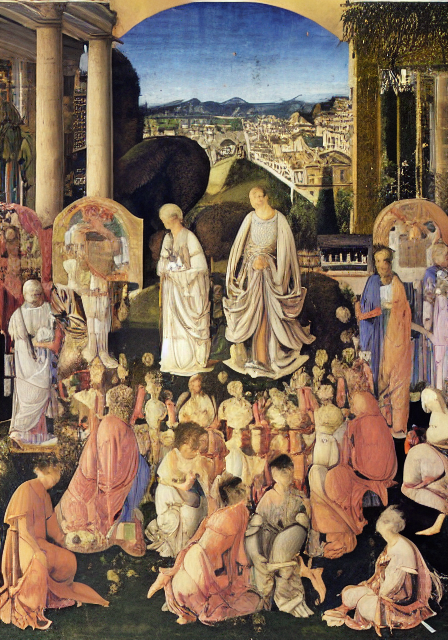

--------------------
Score:

In [ ]:
#@markdown code for genetic algorithm *mostly* generated by code-davinci-002 <br>
#@markdown comes pre-loaded with the first 20 pages of the most popular danbooru tags (https://danbooru.donmai.us/tags?commit=Search&page=1&search%5Bhide_empty%5D=yes&search%5Border%5D=count) <br>
#@markdown and the word lists here: https://github.com/pharmapsychotic/clip-interrogator/tree/main/data <br>
#@markdown **the first generation will take a while, as it's downloading the model** <br><br>
#@markdown use any scoring system you want! 1-10, 1-3, whatever as long as the higher number is favorable
import random
from IPython.display import display, Image
from IPython.display import clear_output
from google.colab import output
# wordlist = input("words:").split(" ")
# wordlist = "1girl solo highres long_hair commentary_request breasts looking_at_viewer blush smile short_hair open_mouth bangs blue_eyes multiple_girls blonde_hair skirt brown_hair large_breasts simple_background black_hair shirt hair_ornament red_eyes thighhighs absurdres hat gloves 1boy bad_id long_sleeves white_background dress original ribbon touhou bow navel 2girls bad_pixiv_id photoshop_(medium) holding animal-ears cleavage hair_between_eyes brown_eyes bare_shoulders twintails medium_breasts commentary jewelry sitting very_long_hair underwear closed_mouth nipples school_uniform green_eyes blue_hair standing purple_eyes collarbone panties monochrome tail jacket translated swimsuit full_body closed_eyes hair_ribbon kantai_collection yellow_eyes weapon ponytail purple_hair upper_body ass pink_hair comic white_shirt braid flower ahoge short_sleeves greyscale hair_bow hetero male_focus heart pantyhose bikini white_hair sidelocks nude thighs red_hair cowboy_shot pleated_skirt sweat translation_request hairband small_breasts earrings boots multicolored_hair lying censored frills parted_lips detached_sleeves one_eye_closed outdoors food japanese_clothes multiple_boys green_hair wings open_clothes sky necktie horns shoes penis fate_(series) grey_hair glasses barefoot shorts serafuku silver_hair pussy teeth day solo_focus sleeveless choker alternate_costume tongue pointy_ears socks black_gloves elbow_gloves hairclip fang striped midriff puffy_sleeves shiny looking_back belt sword official_art collared_shirt pants cloud artist_name black_thighhighs tears fate/grand_order cat_ears indoors white_gloves 3girls hair_flower signature virtual_youtuber dark_skin hand_up spread_legs cum 2boys idolmaster hood sex miniskirt wide_sleeves tongue_out fingerless_gloves on_back blunt_bangs black_skirt bowtie armpits pink_eyes sailor_collar black_legwear kimono english_commentary pokemon medium_hair water grey_background necklace chibi off_shoulder bag clothes_lift hair_bun scarf"#@param {"type":"string"}
# wordlist = wordlist.split(" ")

diffusers_model = "doohickey/trinart-waifu-diffusion-50-50" #@param {type:"string"}
steps = 45 #@param
scale = 8 #@param
height = 640 #@param 
width = 448 #@param
use_danbooru_tags = False #@param {type:"boolean"}
use_interrogator_concepts = True #@param {type:"boolean"}
keep_top_fraction = 0.5 #@param
mutation_rate = 0.1 #@param
crossover_rate = 0.25 #@param
wordlist = []
if use_danbooru_tags == True:
    wordlist += open("danbooru_tags.txt", "r").read().split(" ")
    wordlist += open("danbooru_2.txt", "r").read().split(" ")
    if use_interrogator_concepts:
        wordlist = wordlist * 25 # the other ones are so long it gets under-represented
if use_interrogator_concepts == True:
    wordlist += [i.replace("\n","") for i in open("artists.txt", "r").readlines()]
    wordlist += [i.replace("\n","") for i in open("movements.txt", "r").readlines()]
    wordlist += [i.replace("\n","") for i in open("flavors.txt", "r").readlines()]
    wordlist += [i.replace("\n","") for i in open("mediums.txt", "r").readlines()]

base = "" #@param {type:"string"}
prompt_length = 12 #@param
population = 4 #@param
clear_after_each_generation = True #@param {type:"boolean"}

class Population:
    def __init__(self, size):
        self.size = size
        self.members = []
        for i in range(size):
            self.members.append(Member())
        self.fitness = []
        self.best = None
        self.best_fitness = 0
        self.avg_fitness = 0
        self.generation = 0
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.top_frac = keep_top_fraction
    def get_fitness(self):
        if clear_after_each_generation:
            clear_output(wait=False)
        print("Current Generation", self.generation)
        # print string and use input to get fitness from user
        for member in self.members:
            current_prompt = ((base + " " + member.string) if len(base) > 1 else member.string)
            print("="*20)

            # im re-loading the model every time because i want NO chance of a memory leak, 
            # imagine you sit here for an hour and then BOOM cuda oom? that would SUCK
            t_0 = time.time()
            !python doohickey-slim.py "$current_prompt" $height $width "$diffusers_model" $steps $scale
            t_1 = time.time()
            output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')
            print(f"Took {t_1-t_0} seconds.")
            display(Image("progress.png"))
            print("-"*20)
            # member.fitness = float(input("fitness:"))
            a = %sx read -p "Score:"
            a = a[0].replace("Score:","").replace(" ", "")
            if len(a)<1 or a==" ":
                a = self.avg_fitness
            member.fitness = float(a) + random.random() * 0.01 # so that if you have all the same number it wont error
            print("Your score:", member.fitness)

            if member.fitness > self.best_fitness:
                self.best_fitness = member.fitness
                self.best = member
            self.fitness.append(member.fitness)
        # dude idk codex wrote this all so weird i have to shoe-horn the stuff for actually ranking in   
        self.avg_fitness = sum(self.fitness)/len(self.fitness)
    def next_generation(self):
        # create new generation
        self.generation += 1
        new_members = []
        print(sorted(self.fitness))
        self.members = list(reversed([x for _, x in sorted(zip(self.fitness, self.members), key=lambda pair: pair[0])]))
        for i in range(self.size):
            # select parents
            parent1 = self.members[random.randint(0, round(self.size*self.top_frac))]
            parent2 = self.members[random.randint(0, round(self.size*self.top_frac))]
            # crossover
            if random.random() < self.crossover_rate:
                child = parent1.crossover(parent2)
            else:
                child = parent1
            # mutate
            if random.random() < self.mutation_rate:
                child.mutate()
            new_members.append(child)
        self.members = new_members
        self.fitness = []

class Member:
    def __init__(self):
        self.string = ""
        for i in range(prompt_length):
            self.string += wordlist[random.randint(0, len(wordlist)-1)] + " "
        self.fitness = 0
    def mutate(self):
        # mutate string
        self.string = ""
        for i in range(prompt_length):
            self.string += wordlist[random.randint(0, len(wordlist)-1)] + " "
    def crossover(self, other):
        # crossover strings
        child = Member()
        child.string = ""
        for i in range(prompt_length):
            if random.random() < 0.5:
                child.string += self.string.split(" ")[i] + " "
            else:
                child.string += other.string.split(" ")[i] + " "
        return child

population = Population(population)

while True:
    population.get_fitness()
    print("generation:", population.generation)
    print("best fitness:", population.best_fitness)
    print("best member:", population.best.string)
    print("average fitness:", population.avg_fitness)
    population.next_generation()

### tip:
it's good to have a specific scoring criteria, for example:
```
0 - no waterbottle
1 - waterbottle in picture
2 - waterbottle is main focus
3 - waterbottle is main focus + image is aesthetically pleasing
```

```
-1 - dislike
0 - neutral
1 - like
```

another thing if you aren't sure of your scoring criteria, is to set the first image of each generation at the middle of your range (5 if 1-10) and base the rest from there.